In [1]:
import os
import torch 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
training_data_path = "./data/10monkey/training/training"
testing_data_path = "./data/10monkey/validation/validation"

In [3]:
os.listdir(training_data_path) , os.listdir(testing_data_path)

(['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'],
 ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'])

## Calculate mean and std of images in dataset 

In [4]:
# transforsm
training_transform = transforms.Compose(
    [transforms.Resize((224 , 224)) , transforms.ToTensor()] 
)

# dataset
train_datset = torchvision.datasets.ImageFolder(
    root= training_data_path , transform= training_transform
)

# dataloader
train_loader = torch.utils.data.DataLoader(dataset= train_datset , batch_size=32 , shuffle = False)

In [5]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images = 0

    for images, _ in train_loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch , images.size(1) , -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

        total_images += image_count_in_a_batch
    
    mean /= total_images
    std /= total_images

    return mean , std

In [6]:
mean , std = get_mean_and_std(train_loader)
print(f"mean = {mean}")
print(f"std = {std}")


mean = tensor([0.4363, 0.4328, 0.3291])
std = tensor([0.2129, 0.2075, 0.2037])


## Image dataset preparation in PyTorch (Dataloaders and Transforms)

In [7]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2037]

In [8]:
# the transfomrs 

train_transform = transforms.Compose(
    [
        transforms.Resize((224,224)), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.tensor(mean) , torch.tensor(std))        
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(torch.tensor(mean) , torch.tensor(std)) 
    ]
)

In [9]:
# dataset class 

train_dataset = torchvision.datasets.ImageFolder(root= training_data_path , transform= train_transform)
test_dataset = torchvision.datasets.ImageFolder(root= testing_data_path , transform= test_transform) 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labes tensor([6, 3, 8, 1, 8, 4]) 


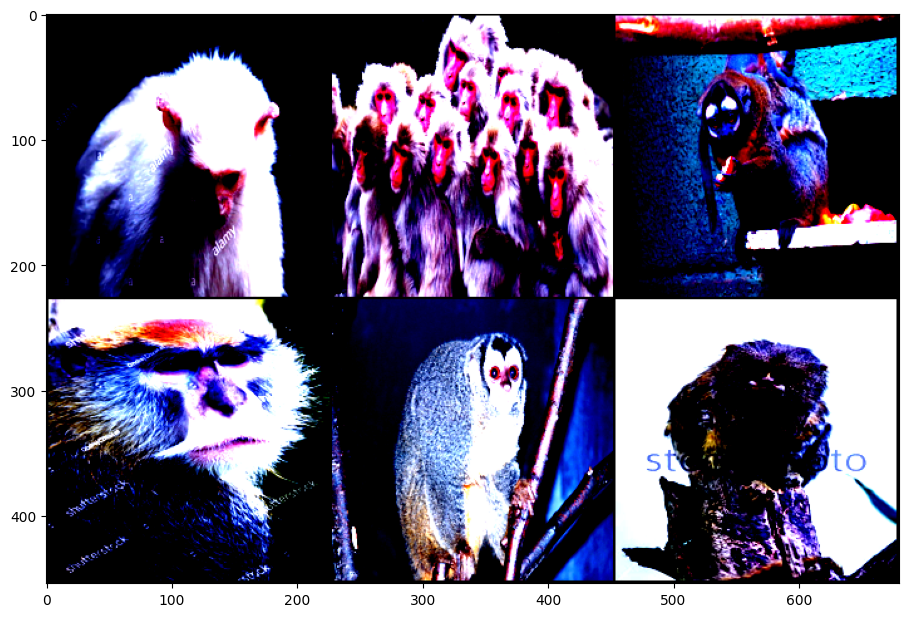

In [10]:
import numpy as np 
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset , batch_size= 6 , shuffle= True)
    batch = next(iter(loader))

    images , labels = batch
    print(f"labes {labels} ")
    grid = torchvision.utils.make_grid(images , nrow= 3)
    grid = np.transpose(grid , (1,2,0))
    plt.figure(figsize=(11,11))
    plt.imshow(grid)


show_transformed_images(test_dataset)

In [11]:

train_loader = torch.utils.data.DataLoader(train_dataset , batch_size= 32 , shuffle= True)
test_loader = torch.utils.data.DataLoader(test_dataset , batch_size= 32 , shuffle= False)


In [12]:
def set_device():
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    
    return torch.device(device)

In [13]:
import torchvision.models as models
import torch.nn as nn 
import torch.optim as optim 

resnet_18_model = models.resnet18(weights=None)
num_features = resnet_18_model.fc.in_features
num_monkey_class = 10
resnet_18_model.fc = nn.Linear(num_features , num_monkey_class)

device = set_device()
resnet_18_model = resnet_18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    resnet_18_model.parameters() , lr = 0.01 , momentum= 0.9 , weight_decay= 0.003
)


In [18]:

#Training the CNN
num_epochs = 25

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    print(f"Epoch {epoch + 1} / {num_epochs}")
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    resnet_18_model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_loader):
        

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = resnet_18_model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.item()         # Accumulate the loss
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))

    print(f"Training Accuracy: {train_accuracy[-1]} , Training loss: {train_loss[-1]}")

    #Testing
    testing_loss = 0.0
    correct = 0
    iterations = 0

    resnet_18_model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_loader):


        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = resnet_18_model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    
    print(f"Testing Accuracy: {test_accuracy[-1]} , Testing loss: {test_loss[-1]}")


Epoch 1 / 25
Training Accuracy: 51.59526062011719 , Training loss: 1.3635166236332485
Testing Accuracy: 41.54411697387695 , Testing loss: 1.7741980287763808
Epoch 2 / 25
Training Accuracy: 52.415679931640625 , Training loss: 1.283415184702192
Testing Accuracy: 41.17647171020508 , Testing loss: 2.010786122745938
Epoch 3 / 25
Training Accuracy: 55.42388153076172 , Training loss: 1.2268657871655055


In [ ]:
    def plot_accuracy(self, history):
        training_accuracy = history.history['accuracy']
        validation_accuracy = history.history['val_accuracy']
        plt.plot(training_accuracy,'r',linewidth=3.0)
        plt.plot(validation_accuracy,'b',linewidth=3.0)
        plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
        plt.xlabel('Epochs ',fontsize=16)
        plt.ylabel('Accuracy',fontsize=16)
        plt.title('Accuracy Curves',fontsize=16)
        plt.show()
        
    def plot_loss(self ,history):
        
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']
        plt.plot(training_loss,'m',linewidth=3.0)
        plt.plot(validation_loss,'c',linewidth=3.0)
        plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
        plt.xlabel('Epochs ',fontsize=16)
        plt.ylabel('Loss',fontsize=16)
        plt.title('Loss Curves',fontsize=16)
        plt.show()
